# KB4 Visualization

In [1]:
# Define the constants for the camera model
FX, FY, CU, CV, K1, K2, K3, K4 = 622, 622, 965, 631, -0.256, -0.0015, 0.0007, -0.0002
IMAGE_WIDTH, IMAGE_HEIGHT = 1920, 1200

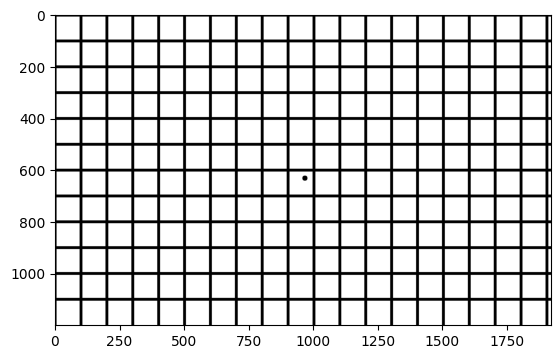

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def create_grid_image(image_width: int, image_height: int, image_center_x: int, image_center_y: int) -> np.ndarray:
    """
    Create a greyscale grid image of the given size with the given center.
    Parameters
    ----------
    image_width : int
        The width of the image.
    image_height : int
        The height of the image.
    image_center_x : int
        The x-coordinate of the center of the image.
    image_center_y : int
        The y-coordinate of the center of the image.
    Returns
    -------
    np.ndarray
        The grid image.
    """

    grid_image = np.ones((image_height, image_width), dtype=np.uint8) * 255

    # Draw the grid
    for i in range(0, image_height, 100):
        cv2.line(grid_image, (0, i), (image_width, i), thickness=10, color=0)
    for j in range(0, image_width, 100):
        cv2.line(grid_image, (j, 0), (j, image_height), thickness=10, color=0)

    # Draw the center of the image
    cv2.circle(grid_image, (image_center_x, image_center_y), radius=10, color=0, thickness=-1)

    return grid_image

grid_image = create_grid_image(IMAGE_WIDTH, IMAGE_HEIGHT, CU, CV)
plt.imshow(grid_image, cmap='gray')
plt.savefig('undistorted_grid_image.png')

In [3]:
# Get the undistorted points (only need the black pixels)
undistorted_points = np.argwhere(grid_image == 0)
undistorted_points = undistorted_points[:, [1, 0]] # swap the dimensions

print(f"Undistorted points: {undistorted_points}")
print(f"Undistorted points shape: {undistorted_points.shape}")

Undistorted points: [[   0    0]
 [   1    0]
 [   2    0]
 ...
 [1903 1199]
 [1904 1199]
 [1905 1199]]
Undistorted points shape: (474852, 2)


In [4]:
# Get the matrix K and D
K = np.array([[FX, 0, CU], [0, FY, CV], [0, 0, 1]], dtype=np.float32)
D = np.array([K1, K2, K3, K4], dtype=np.float32)

# Get the matrix K^(-1)
# K_inv = np.linalg.inv(K)
K_inv = np.array([[1 / FX, 0, -CU / FX], [0, 1 / FY, -CV / FY], [0, 0, 1]], dtype=np.float32) # Closed-form inverse of K, should be faster than np.linalg.inv

# Convert from image coordinates to camera coordinates
normalized_undistorted_points = cv2.convertPointsToHomogeneous(undistorted_points) # Append 1 to each point to be able to multiply with K_inv
normalized_undistorted_points = np.matmul(K_inv, normalized_undistorted_points.reshape(-1, 3).T).T # Matrix multiplication is probably faster than using loop
normalized_undistorted_points = cv2.convertPointsFromHomogeneous(normalized_undistorted_points) # Remove the appended 1 from each point

distorted_points = cv2.fisheye.distortPoints(normalized_undistorted_points, K, D)

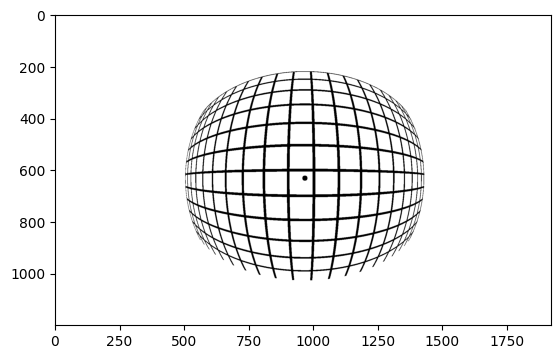

In [5]:
# Create an image from the distorted points
distorted_image = np.ones((IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.uint8) * 255
x_coords = np.round(distorted_points[:, 0, 0]).astype(int)
y_coords = np.round(distorted_points[:, 0, 1]).astype(int)
distorted_image[y_coords, x_coords] = 0

plt.imshow(distorted_image, cmap='gray')

In [6]:
# Implement the fisheye distortion model (converting from OpenCV C++ source code of cv::fisheye::distortPoints)
def fisheye_distort_points(undistorted_points: np.ndarray, K: np.ndarray, D: np.ndarray, alpha: float = 0) -> np.ndarray:
    """
    Apply the fisheye distortion model to the given undistorted points.
    Parameters
    ----------
    undistorted_points : np.ndarray
        The undistorted points.
    K : np.ndarray
        The 3x3 intrinsic matrix.
    D : np.ndarray
        The 1x4 distortion coefficients.
    alpha : float
        The skew coefficient. Default is 0.
    Returns
    -------
    np.ndarray
        The distorted points.
    """

    # Extract the parameters
    fx, fy, cu, cv = K[0, 0], K[1, 1], K[0, 2], K[1, 2]
    k1, k2, k3, k4 = D[0], D[1], D[2], D[3]

    # Compute r, theta, theta_d for all points using vectorized operations instead of loops
    x, y = undistorted_points[:, 0], undistorted_points[:, 1]
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan(r)
    theta_d = theta + k1 * theta**3 + k2 * theta**5 + k3 * theta**7 + k4 * theta**9

    # To avoid division by very small numbers
    inv_r = np.where(r > 1e-8, 1.0 / r, 1)
    cdist = np.where(r > 1e-8, theta_d * inv_r, 1)

    y_d = y * cdist
    x_d = x * cdist + alpha * y_d

    distorted_points = np.column_stack((x_d * fx + cu, y_d * fy + cv))

    return distorted_points

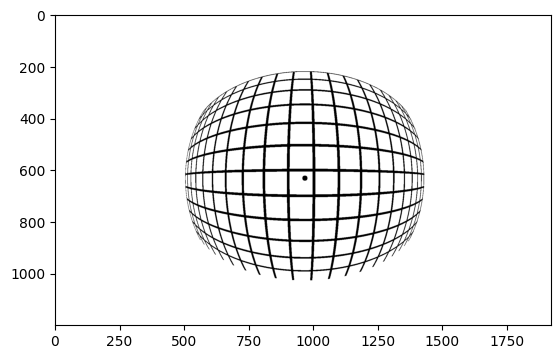

In [7]:
# Use my own implementation of the fisheye distortion model
distorted_points_2 = fisheye_distort_points(normalized_undistorted_points.reshape(-1, 2), K, D)

# Create an image from the distorted points
distorted_image_2 = np.ones((IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.uint8) * 255
x_coords = np.round(distorted_points_2[:, 0]).astype(int)
y_coords = np.round(distorted_points_2[:, 1]).astype(int)
distorted_image_2[y_coords, x_coords] = 0

plt.imshow(distorted_image_2, cmap='gray')
plt.savefig('distorted_grid_image.png')